# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [55]:
df_data0 = pd.read_csv('/datasets/geo_data_0.csv')
df_data1 = pd.read_csv('/datasets/geo_data_1.csv')
df_data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [56]:
display(df_data0.describe())
display(df_data1.describe())
display(df_data2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [57]:
print('Дубликаты в data0:',df_data0.duplicated().sum())
print('Дубликаты в data1:',df_data1.duplicated().sum())
print('Дубликаты в data2:',df_data2.duplicated().sum())

Дубликаты в data0: 0
Дубликаты в data1: 0
Дубликаты в data2: 0


In [58]:
display(df_data0.nunique())
display(df_data1.nunique())
display(df_data2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [59]:
df_data1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

In [60]:
print('Общий объем по региону №0 = {:.2f} тыс. баррелей'.format(df_data0['product'].sum()))
print('Общий объем по региону №1 = {:.2f} тыс. баррелей'.format(df_data1['product'].sum()))
print('Общий объем по региону №2 = {:.2f} тыс. баррелей'.format(df_data2['product'].sum()))

Общий объем по региону №0 = 9250000.00 тыс. баррелей
Общий объем по региону №1 = 6882500.00 тыс. баррелей
Общий объем по региону №2 = 9500000.00 тыс. баррелей


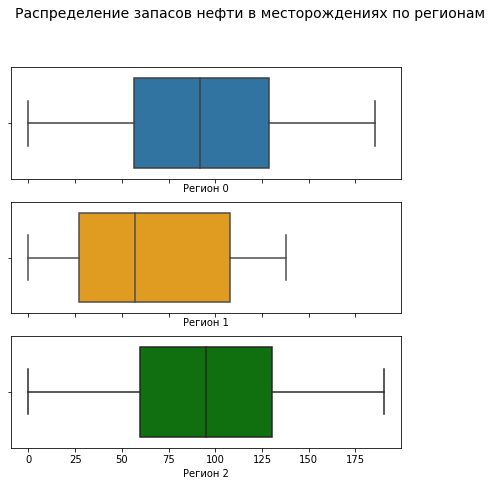

In [73]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(7,7))

sns.boxplot(df_data0['product'], ax=axes[0])
sns.boxplot(df_data1['product'], ax=axes[1], color='orange')
sns.boxplot(df_data2['product'], ax=axes[2], color='green')

axes[0].set_xlabel('Регион 0')
axes[1].set_xlabel('Регион 1')
axes[2].set_xlabel('Регион 2')

fig.suptitle('Распределение запасов нефти в месторождениях по регионам', size=14, y=1, x=0.6)
plt.show()

### Выводы:
 - Данные подготовлены, пропусков и дублей нет, формат данных нормальный.
 - Вопрос по региону№1, данные по всей видимости категоризированны, всего 12 значений. Результаты буду не коррктены по этому региону.
 - Лидируют по запасам регионы 0 и 1

## Обучение и проверка модели

In [62]:
def predictoins_region(df):
    features = df.drop(['product','id'],axis = 1) 
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state=1234)
    model = LinearRegression(n_jobs=-1).fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse ** 0.5

    stock_mean = df['product'].mean()
    stock_mean_pred = predictions.mean()
    
    target_valid = target_valid.reset_index(drop=True)
    
    return predictions, rmse, stock_mean_pred, target_valid

In [63]:
predictions_0, rmse_0, stock_mean_pred_0, target_valid_0 = predictoins_region(df_data0)

print('RMSE модели в регионе №0 = {:.3f}'.format(rmse_0))
print('Средний запас предсказанного сырья в регионе №0 = {:.3f} тыс. баррелей'.format(stock_mean_pred_0)) 
print('Реальный средний запас сырья в регионе №0 = {:.3f} тыс. баррелей'.format(target_valid_0.mean())) 

RMSE модели в регионе №0 = 37.562
Средний запас предсказанного сырья в регионе №0 = 92.430 тыс. баррелей
Реальный средний запас сырья в регионе №0 = 92.580 тыс. баррелей


In [64]:
predictions_1, rmse_1, stock_mean_pred_1, target_valid_1 = predictoins_region(df_data1)

print('RMSE модели в регионе №1 = {:.3f}'.format(rmse_1))
print('Средний запас предсказанного сырья в регионе №1 = {:.3f} тыс. баррелей'.format(stock_mean_pred_1)) 
print('Реальный средний запас сырья в регионе №1 = {:.3f} тыс. баррелей'.format(target_valid_1.mean())) 

RMSE модели в регионе №1 = 0.894
Средний запас предсказанного сырья в регионе №1 = 68.802 тыс. баррелей
Реальный средний запас сырья в регионе №1 = 68.803 тыс. баррелей


In [65]:
predictions_2, rmse_2, stock_mean_pred_2, target_valid_2 = predictoins_region(df_data2)

print('RMSE модели в регионе №2 = {:.3f}'.format(rmse_2))
print('Средний запас предсказанного сырья в регионе №2 = {:.3f} тыс. баррелей'.format(stock_mean_pred_2)) 
print('Реальный средний запас сырья в регионе №2 = {:.3f} тыс. баррелей'.format(target_valid_2.mean())) 

RMSE модели в регионе №2 = 40.103
Средний запас предсказанного сырья в регионе №2 = 94.916 тыс. баррелей
Реальный средний запас сырья в регионе №2 = 94.972 тыс. баррелей


### Вывод:
 - Модель региона №1 показала наилучший результат RMSE, не удивительно, предсказывать проще 
 - Возможно для обучения можно объеденить обучающие выборки для все регионов, показатели то имеют общий смысл...наверное
 - Самые богатые регионы по запасам, это регионы №0 и №2

## Подготовка к расчёту прибыли

In [66]:
budget = 10000000000   #Бюджет 
total_points = 500 #при разведке региона исследуют 500 точек
total_best_points = 200  # 200 лучших скважин 
profit_from_one_product = 450000   #Доход с каждой единицы продукта 450 000 рублей

In [67]:
required_volume_mean = budget / total_best_points / profit_from_one_product
print('Средний объем сырья для безубыточной разработки новой скважины {:.2f} тыс. баррелей'.format(required_volume_mean))

Средний объем сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей


In [68]:
required_volume_sum = budget / profit_from_one_product
print('Общий объем сырья для безубыточной разработки в регионе {:.2f} тыс. баррелей на 200 месторождений'.format(required_volume_sum))

Общий объем сырья для безубыточной разработки в регионе 22222.22 тыс. баррелей на 200 месторождений


In [74]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (profit_from_one_product * selected.sum() - budget)


### Вывод:
 - Средний объем сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей, по среднему ниодин регион не проходит, найдем 200 лучших месторождений в каждом регионе
 

## Расчёт прибыли и рисков 

In [69]:
print('Прибыль региона №0: {:.2f} млн. рублей'.format(revenue(target_valid_0, pd.Series(predictions_0),200)/10**6))
print('Прибыль региона №1: {:.2f} млн. рублей'.format(revenue(target_valid_1, pd.Series(predictions_1),200)/10**6))
print('Прибыль региона №2: {:.2f} млн. рублей'.format(revenue(target_valid_2, pd.Series(predictions_2),200)/10**6))

Прибыль региона №0: 3424.03 млн. рублей
Прибыль региона №1: 2415.09 млн. рублей
Прибыль региона №2: 2554.96 млн. рублей


In [71]:
state = np.random.RandomState(12345)
def calc_bootstrap(target,probabilities, reg):
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace = True, random_state = state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample, 200))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    chance_loss = (values < 0).mean()
    interval = (values.quantile(0.025), values.quantile(0.975))
    mean = values.mean()
    print(reg)
    print('Средняя прибыль:{:.3f} млн. рублей'.format(mean/10**6))
    print('Доверительный интервал среднего:{}'.format(interval))
    print('2.5%-квантиль:{:.3f} млн. рублей'.format(lower/10**6))
    print('Риск:{:.2%}'.format(chance_loss))
    print('\n')
    
calc_bootstrap(target_valid_0, pd.Series(predictions_0), 'Регион №0')
calc_bootstrap(target_valid_1, pd.Series(predictions_1), 'Регион №1')
calc_bootstrap(target_valid_2, pd.Series(predictions_2), 'Регион №2')

Регион№0
Средняя прибыль:411.854 млн. рублей
Доверительный интервал среднего:(-153036113.10503384, 909822726.6300966)
2.5%-квантиль:-153.036 млн. рублей
Риск:6.50%


Регион№1
Средняя прибыль:475.927 млн. рублей
Доверительный интервал среднего:(74247290.95463684, 906509048.4226354)
2.5%-квантиль:74.247 млн. рублей
Риск:1.30%


Регион№2
Средняя прибыль:382.102 млн. рублей
Доверительный интервал среднего:(-183916236.36915794, 946554521.4354271)
2.5%-квантиль:-183.916 млн. рублей
Риск:9.70%




### Вывод:
 - Самый "верный" выбор: Регион №1, но там данные разбиты на 12 категорий, это ставит под сомнение выбор.

## Общий вывод:
- По всем метрикам следует выбрать для разработки Регион №1, но для этого нужно уточнить по показателям у заказчика, о идентичности происхождения, тогда можно будет перемешать обучающие выборки, обучить модель и сделать прогноз основываясь на этих данных, либо уточнить значения.
- "Самый средний" регион - №0, по общим запасам он близок к №2, который является крупнейшим. Риск меньше, чем у того же №2.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован